In [1]:
import matplotlib.pyplot as plt
import numpy as np
from fdm_laser import FDM_Laser, HeatSourceLaser

In [2]:
# Realistic material properties for steel/laser processing
I0 = 5e9      # Laser intensity (W/m²)
a = 0.8       # Absorption coefficient
K = 35        # Thermal conductivity (W/m·K)
C = 500       # Specific heat capacity (J/kg·K)
rho = 7700    # Density (kg/m³)
theta_w = 300 # Wall temperature (K)
theta0 = 300  # Initial temperature (K)

In [3]:
# Fixed parameters
dt = 10e-2     # Time step (s)
tf = 10      # Final time (s)
N = 51        # Grid size
l = 0.2      # Domain size (m)

Visualizing laser path...
len(self.path): 64


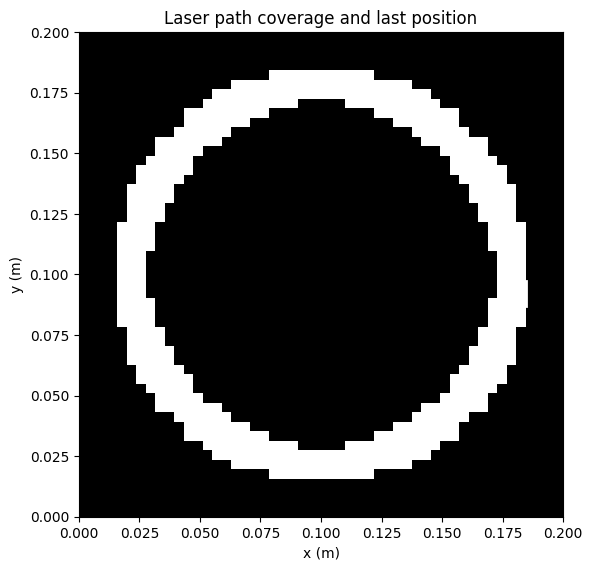

In [4]:
# Laser setup
laser_center = (l/2, l/2)
laser_dr = 0.005
n_path = 64

path = 'circle'
if path == 'single_point':
    path_points = None
elif path == 'circle':
    path_points = HeatSourceLaser.make_path(
        mode='circle', l=l, n_path=n_path, center=laser_center, radius=0.08
    )
elif path == 'rectangle':
    path_points = HeatSourceLaser.make_path(
        mode='rectangle', l=l, n_path=n_path, center=laser_center, width=0.16, height=0.10
    )
else:
    raise ValueError(f'Invalid path: {path}')

path_dt = 0.2  # Move laser every 0.2 seconds
laser = HeatSourceLaser(dr=laser_dr, path=path_points, path_dt=path_dt, center=laser_center)

# Visualize the path
print('Visualizing laser path...')
laser.visualize_path(l, N)

In [5]:
# Create FDM_Laser instance
fdm = FDM_Laser(N, l, dt, tf, K, rho, C, theta0, theta_w, a, I0, laser, write_output=True)
# Choose which method to use
solve_method = 'matmul'  # or 'loop'
print(f'Running {solve_method}-based FDM...')
final_temp = fdm.solve(update_fn=solve_method)
print(f"{solve_method.capitalize()}-based: max temp = {np.max(final_temp):.2f}, min temp = {np.min(final_temp):.2f}")

Running matmul-based FDM...
solve took 4.257 seconds.
Matmul-based: max temp = 685.77, min temp = 300.00


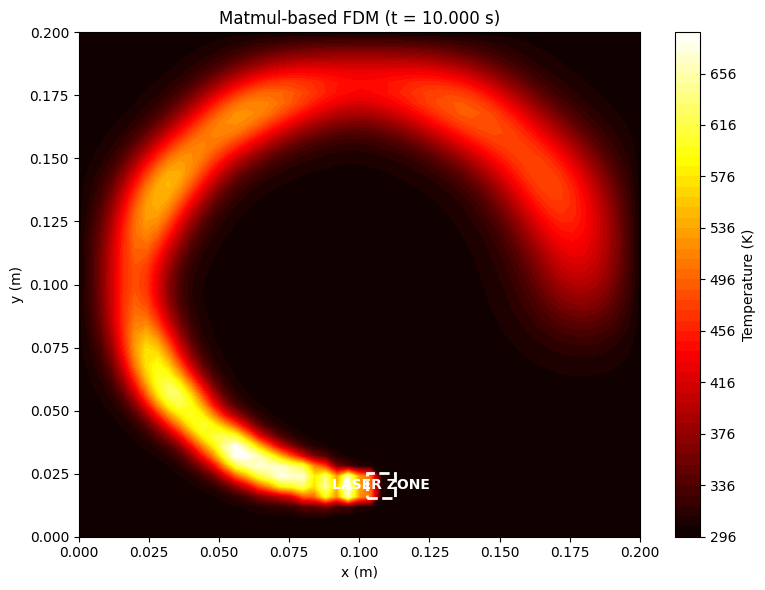

In [6]:
# Plot the result
plt.figure(figsize=(8, 6))
im = plt.contourf(fdm.X, fdm.Y, final_temp.T, levels=50, cmap='hot')
plt.colorbar(im, label='Temperature (K)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(f'{solve_method.capitalize()}-based FDM (t = {tf:.3f} s)')
xl_min, xl_max, yl_min, yl_max = laser.get_bounds()
laser_zone = plt.Rectangle((xl_min, yl_min), xl_max-xl_min, yl_max-yl_min, 
                            fill=False, edgecolor='white', linewidth=2, linestyle='--')
plt.gca().add_patch(laser_zone)
plt.text((xl_min + xl_max)/2, (yl_min + yl_max)/2, 'LASER ZONE', 
            ha='center', va='center', color='white', fontweight='bold')
plt.tight_layout()
plt.show() 

In [7]:
def plot_input_output(fdm, step_idx, tf=None):
    """
    Plot input and output temperature fields side by side for a given timestep.
    
    Args:
        fdm: FDM_Laser instance with saved data
        step_idx: Index of timestep to plot
        tf: Final time (optional, for title)
    """
    if not fdm.write_output or len(fdm.save_dict['input']) == 0:
        print("No saved data available. Make sure write_output=True when creating FDM_Laser.")
        return
    
    if step_idx >= len(fdm.save_dict['input']):
        print(f"Step index {step_idx} out of range. Max index: {len(fdm.save_dict['input'])-1}")
        return
    
    input_temp = fdm.save_dict['input'][step_idx]
    output_temp = fdm.save_dict['output'][step_idx]
    
    # Create side-by-side subplots
    plt.figure(figsize=(16, 6))
    
    # Input (left subplot)
    plt.subplot(1, 2, 1)
    im1 = plt.contourf(fdm.X, fdm.Y, input_temp.T, levels=50, cmap='hot')
    plt.colorbar(im1, label='Temperature (K)')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(f'Input (t = {step_idx * fdm.dt:.3f} s)')
    
    # Output (right subplot)
    plt.subplot(1, 2, 2)
    im2 = plt.contourf(fdm.X, fdm.Y, output_temp.T, levels=50, cmap='hot')
    plt.colorbar(im2, label='Temperature (K)')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(f'Output (t = {(step_idx + 1) * fdm.dt:.3f} s)')
    
    plt.tight_layout()
    plt.show()

100


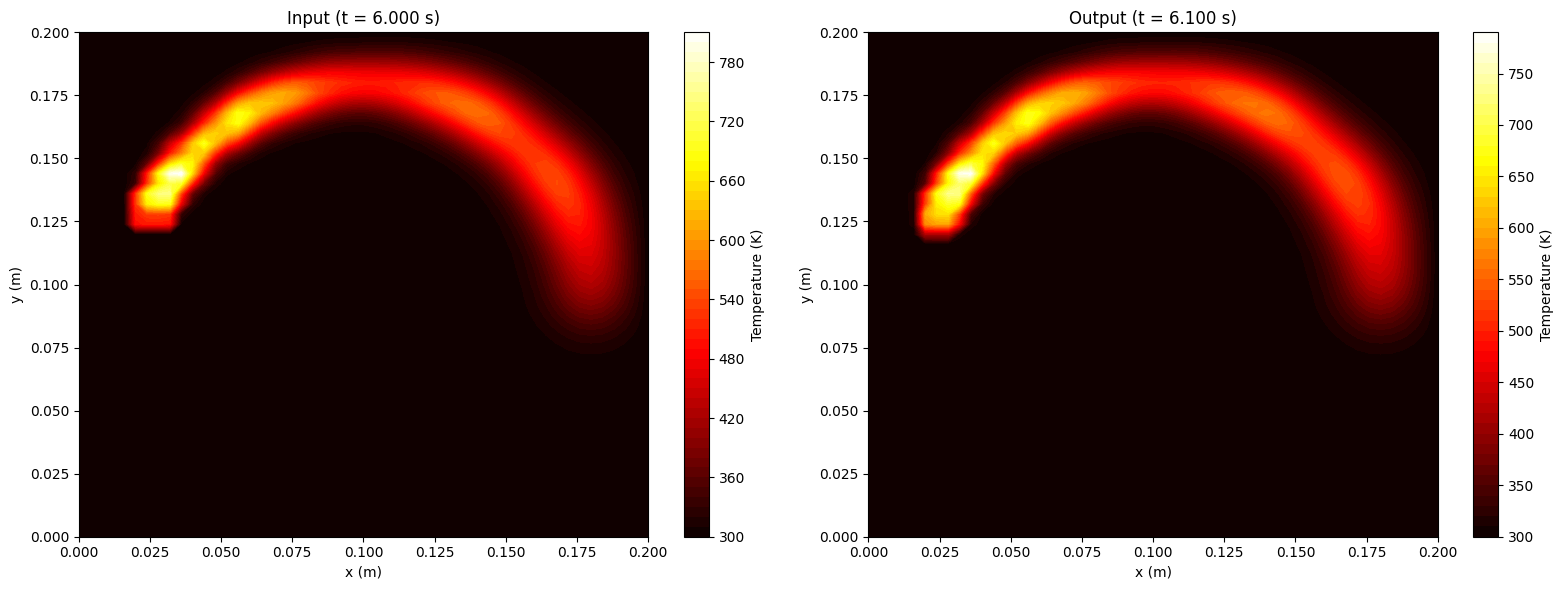

In [9]:
# Usage example:
tf = len(fdm.save_dict['output'])
print(tf)
plot_input_output(fdm, 60)  # Plot timestep 50